<a href="https://colab.research.google.com/github/alqamahsayeed12/Air-Quality-Trainings/blob/Module-5/Module_5_read_and_map_geos_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Module**: read_and_map_geos_final.ipynb

**Organization**: NASA ARSET

**Author**: Alqamah Sayeed, and Pawan Gupta

**Date**: February 2022

**Purpose**: read NASA GEOS model ouputs over a given region of the world. The code support reading of GEOS-FP, GEOS-CF, and MERRA2 Aerosols/Gases Datasets. This is sample code and users should modify it according to their own purpose.

**Disclaimer**: The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

**Input and Output**: The code is currently setup to read data from local google drive and tested to work on Google Colab platform.

In [ ]:
# Step 1 - Mounting The Google Drive. User will need to give access to their Google drive for reading/writing data
from google.colab import drive
drive.mount('/content/drive')

root = "/content/drive/MyDrive/Guatemala_Training/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2 - Installing some useful Python Packages. This can take some time depending your internet speed.
!pip uninstall -y shapely;
!apt-get install libgeos-dev
!pip install cython
!pip install netcdf4
#!apt-get -qq install python-cartopy python3-cartopy;
!pip install wget
!pip install --no-binary shapely shapely --force
!apt-get install -qq libgdal-dev libproj-dev
!pip install cartopy

Found existing installation: shapely 2.0.6
Uninstalling shapely-2.0.6:
  Successfully uninstalled shapely-2.0.6
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
  Using cached shapely-2.0.6-cp310-cp310-linux_x86_64.whl
  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.3 which is inc

In [ ]:
# Step 3 - Importing packages to be used in the code for data processing
from datetime import date
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import numpy.ma as ma
import matplotlib
import glob
import wget
import matplotlib.ticker as ticker
import matplotlib.patheffects as PathEffects
from matplotlib.ticker import AutoMinorLocator
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import os, gc
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import warnings
warnings.filterwarnings('ignore')
import pytz
from datetime import datetime
import urllib
import pandas as pd
from scipy.stats import linregress
import math
from sklearn.metrics import mean_squared_error as MSE
import matplotlib as mpl
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import numpy as np
#city_lat, city_lon = 14.989397, -90.522408

import pandas as pd
from copy import deepcopy as dc

In [ ]:
# AR-1A (Additional Resource) - This function is download the MERRA2 data
# Currently setup to work only when MERRA2 data are not present in the current dir.
##Initialise Module to download MERRA-2 DATA
##Source : https://github.com/emilylaiken/merradownload
# TODO: Change and describe structure of the links that have to be provided.
# TODO: Proper readme with examples.

from multiprocessing.dummy import Pool as Threadpool
import requests
import logging
import yaml
import os
import urllib.response
from http import cookiejar
import urllib.error
import urllib.request
import re

log = logging.getLogger('opendap_download')

class DownloadManager(object):
    __AUTHENTICATION_URL = 'https://urs.earthdata.nasa.gov/oauth/authorize'
    __username = ''
    __password = ''
    __download_urls = []
    __download_path = ''
    _authenticated_session = None

    def __init__(self, username='', password='', links=None, download_path='download'):
        self.set_username_and_password(username, password)
        self.download_urls = links
        self.download_path = download_path

        if logging.getLogger().getEffectiveLevel() == logging.INFO:
            logging.getLogger("requests").setLevel(logging.CRITICAL)
            logging.getLogger("urllib3").setLevel(logging.CRITICAL)

        log.debug('Init DownloadManager')

    @property
    def download_urls(self):
        return self.__download_urls

    @download_urls.setter
    def download_urls(self, links):
        """
        Setter for the links to download. The links have to be an array containing the URLs. The module will
        figure out the filename from the url and save it to the folder provided with download_path()
        :param links: The links to download
        :type links: List[str]
        """
        # TODO: Check if links have the right structure? Read filename from links?
        # Check if all links are formed properly
        if links is None:
            self.__download_urls = []
        else:
            for item in links:
                try:
                    self.get_filename(item)
                except AttributeError:
                    raise ValueError('The URL seems to not have the right structure: ', item)
            self.__download_urls = links

    @property
    def download_path(self):
        return self.__download_path

    @download_path.setter
    def download_path(self, file_path):
        self.__download_path = file_path

    def set_username_and_password(self, username, password):
        self.__username = username
        self.__password = password

    def read_credentials_from_yaml(self, file_path_to_yaml):
        with open(file_path_to_yaml, 'r') as f:
            credentials = yaml.load(f)
            log.debug('Credentials: ' + str(credentials))
            self.set_username_and_password(credentials['username'], credentials['password'])

    def _mp_download_wrapper(self, url_item):
        """
        Wrapper for parallel download. The function name cannot start with __ due to visibility issues.
        :param url_item:
        :type url_item:
        :return:
        :rtype:
        """
        query = url_item
        file_path = os.path.join(self.download_path, self.get_filename(query))
        self.__download_and_save_file(query, file_path)

    def start_download(self, nr_of_threads=4):
        if self._authenticated_session is None:
            self._authenticated_session = self.__create_authenticated_sesseion()
        # Create the download folder.
        os.makedirs(self.download_path, exist_ok=True)
        # p = multiprocessing.Pool(nr_of_processes)
        p = Threadpool(nr_of_threads)
        p.map(self._mp_download_wrapper, self.download_urls)
        p.close()
        p.join()

    @staticmethod
    def get_filename(url):
        """
        Extracts the filename from the url. This method can also be used to check
        if the links have the correct structure
        :param url: The MERRA URL
        :type url: str
        :return: The filename
        :rtype: str
        """
        # Extract everything between a leading / and .nc4? . The problem with using this without any
        # other classification is, that the URLs have multiple / in their structure. The expressions [^/]* matches
        # everything but /. Combined with the outer expressions, this only matches the part between the last / and .nc4?
        reg_exp = r'(?<=/)[^/]*(?=.nc4?)'
        file_name = re.search(reg_exp, url).group(0)
        return file_name

    def __download_and_save_file(self, url, file_path):
        r = self._authenticated_session.get(url, stream=True)
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        return r.status_code

    def __create_authenticated_sesseion(self):
        s = requests.Session()
        s.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/40.0.2214.85 Safari/537.36'}
        s.auth = (self.__username, self.__password)
        s.cookies = self.__authorize_cookies_with_urllib()

        if logging.getLogger().getEffectiveLevel() == logging.DEBUG:
            r = s.get(self.download_urls[0])
            log.debug('Authentication Status')
            log.debug(r.status_code)
            log.debug(r.headers)
            log.debug(r.cookies)

            log.debug('Sessions Data')
            log.debug(s.cookies)
            log.debug(s.headers)
        return s

    def __authorize_cookies_with_urllib(self):
        username = self.__username
        password = self.__password
        top_level_url = "https://urs.earthdata.nasa.gov"

        # create an authorization handler
        p = urllib.request.HTTPPasswordMgrWithDefaultRealm()
        p.add_password(None, top_level_url, username, password);

        auth_handler = urllib.request.HTTPBasicAuthHandler(p)
        auth_cookie_jar = cookiejar.CookieJar()
        cookie_jar = urllib.request.HTTPCookieProcessor(auth_cookie_jar)
        opener = urllib.request.build_opener(auth_handler, cookie_jar)

        urllib.request.install_opener(opener)

        try:
            # The merra portal moved the authentication to the download level. Before this change you had to
            # provide username and password on the overview page. For example:
            # goldsmr4.sci.gsfc.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/
            # authentication_url = 'https://goldsmr4.sci.gsfc.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/1980/01/MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4.ascii?U2M[0:1:1][0:1:1][0:1:1]'
            # Changes:
            # Authenticate with the first url in the links.
            # Request the website and initialiaze the BasicAuth. This will populate the auth_cookie_jar
            authentication_url = self.download_urls[0]
            result = opener.open(authentication_url)
            log.debug(list(auth_cookie_jar))
            log.debug(list(auth_cookie_jar)[0])
            log.debug(list(auth_cookie_jar)[1])

        except urllib.error.HTTPError:
            raise ValueError('Username and or Password are not correct!')
        except IOError as e:
            log.warning(e)
            raise IOError
        except IndexError as e:
            log.warning(e)
            raise IndexError('download_urls is not set')

        return auth_cookie_jar

In [ ]:
#https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2024/05/MERRA2_400.tavg1_2d_aer_Nx.20240502.nc4.html
# AR-1B (Additional Resoruces)
# Function to Download MERRA-2
def MERRA_2(date_org,dir,vars):
  #from multi_processing_download import DownloadManager
  y = (str(date_org)[:4])
  m = (str(date_org)[4:6])
  d = (str(date_org)[6:])
  NUMBER_OF_CONNECTIONS=5
  base_url = "https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/"

  generated_URL = [base_url+y+ '/'+m+'/MERRA2_400.tavg1_2d_aer_Nx.'+str(date_org)+".nc4.nc4?"+vars]
  print (generated_URL)
  download_manager = DownloadManager()
  download_manager.set_username_and_password('asayeed', 'Class_training21@')
  download_manager.download_path = dir
  download_manager.download_urls = generated_URL
  download_manager.start_download(NUMBER_OF_CONNECTIONS)

In [ ]:
# AR-2 (Additional Resource)
# A function to download NASA GEOS-FP forecasted aerosol datasets for a given date. The data will be downloaded to Google drive
# The function is only called if you need to download the data. Note that the aerosol data are for every three hours.
def GEOS_FP(date_org,dir):
  print ("Downloading GEOS-FP")
  y = (str(date_org)[:4])
  m = (str(date_org)[4:6])
  d = (str(date_org)[6:])
  endpart = ['_0130.V01.nc4','_0430.V01.nc4','_0730.V01.nc4','_1030.V01.nc4','_1330.V01.nc4','_1630.V01.nc4','_1930.V01.nc4','_2230.V01.nc4','_0130.V01.nc4','_0430.V01.nc4','_0730.V01.nc4','_1030.V01.nc4','_1330.V01.nc4','_1630.V01.nc4','_1930.V01.nc4','_2230.V01.nc4','_0130.V01.nc4','_0430.V01.nc4','_0730.V01.nc4','_1030.V01.nc4','_1330.V01.nc4','_1630.V01.nc4','_1930.V01.nc4','_2230.V01.nc4']
  filelist = []
  for i in range(0,8):
      if i < 8:
          date_mod = str(date_org)
          filegne='https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/forecast/Y'+y+'/M'+m+'/D'+d+'/H00/GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(date_org)+'_00+'+date_mod+endpart[i]
          filelist.append(filegne)
      elif i < 16:
          date_mod = str(date_org+1)
          filegne='https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/forecast/Y'+y+'/M'+m+'/D'+d+'/H00/GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(date_org)+'_00+'+date_mod+endpart[i]
          filelist.append(filegne)
      else:
          date_mod = str(date_org+2)
          filegne='https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/forecast/Y'+y+'/M'+m+'/D'+d+'/H00/GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(date_org)+'_00+'+date_mod+endpart[i]
          filelist.append(filegne)
  for fname in filelist:
      tmp = (fname.split('/'))[-1]
      if not os.path.exists(dir+tmp):
        print(f'Downloading..{fname}')
        wget.download(fname,out = dir+tmp)
        print(f'Downloaded..{fname}')
      else:
        print(f'File Exists..{fname}')



In [ ]:
# AR-3 (Additional Resource)
# A function to download NASA GEOS-CF forecasted air quality datasets for a given date. The data will be downloaded to Google drive
# The function is only called if you need to download the data. Note that the air quality data are for every hour.
def GEOS_CF(date_org,dir):
  y = (str(date_org)[:4])
  m = (str(date_org)[4:6])
  d = (str(date_org)[6:])
  endpart = np.arange(0,24)
  filelist = []
  for i in range(0,24):
          date_mod = str(date_org)
          filegne='https://portal.nccs.nasa.gov/datashare/gmao/geos-cf/v1/das/Y'+y+'/M'+m+'/D'+d+'/GEOS-CF.v01.rpl.aqc_tavg_1hr_g1440x721_v1.'+date_mod+"_"+str(endpart[i]).zfill(2)+'30z.nc4'
          filelist.append(filegne)
  try:
      for fname in filelist:
        tmp = (fname.split('/'))[-1]
        wget.download(fname,out = dir+tmp)
        print(f'Downloaded..{fname}')

  except:
    print ("Some or All Files Missing")


In [ ]:
# Step 5 - Function to read GEOS-CF data file.
def readfile2(fname,domain):
    fh = Dataset(fname, mode='r') # loading dataset to variable
    LAT     = fh.variables['lat'][:]
    LON     = fh.variables['lon'][:]

    # adding domain restrictions
    idy = np.where((LON>=domain[0]) & (LON<=domain[1]))
    idx = np.where((LAT>=domain[3]) & (LAT<=domain[2]))
    i1 = idx[0].min()
    i2 = idx[0].max()+1
    j1 = idy[0].min()
    j2 = idy[0].max()+1

    lon, lat = np.meshgrid(LON, LAT) # adjusting dimensions for plotting ?

    lat = np.array(lat)[i1:i2,j1:j2]
    lon = np.array(lon)[i1:i2,j1:j2]

    CO = fh.variables['CO'][0,0,i1:i2,j1:j2]
    NO2 = fh.variables['NO2'][0,0,i1:i2,j1:j2]
    O3  =fh.variables['O3'][0,0,i1:i2,j1:j2]
    PM25 = fh.variables['PM25_RH35_GCC'][0,0,i1:i2,j1:j2]
    SO2 = fh.variables['SO2'][0,0,i1:i2,j1:j2]
    return lon,lat,CO,NO2,O3,PM25,SO2

In [ ]:
#Step 6 - Function to read a MERRA-2 file with list of parameters
def readfile3(fname,domain):
    fh = Dataset(fname, mode='r') # loading dataset to variable
    LAT     = fh.variables['lat'][:]
    LON     = fh.variables['lon'][:]

    # adding domain restrictions
    idy = np.where((LON>=domain[0]) & (LON<=domain[1]))
    idx = np.where((LAT>=domain[3]) & (LAT<=domain[2]))
    i1 = idx[0].min()
    i2 = idx[0].max()+1
    j1 = idy[0].min()
    j2 = idy[0].max()+1

    lon, lat = np.meshgrid(LON, LAT) # adjusting dimensions for plotting

    lat = np.array(lat)[i1:i2,j1:j2]
    lon = np.array(lon)[i1:i2,j1:j2]

    TOTEXTTAU = np.array(fh.variables['TOTEXTTAU'])[0,i1:i2,j1:j2]
    OCSMASS   = np.array(fh.variables['OCSMASS'])[0,i1:i2,j1:j2]*1e9
    SO2SMASS  = np.array(fh.variables['SO2SMASS'])[0,i1:i2,j1:j2]*1e9
    SO4SMASS  = np.array(fh.variables['SO4SMASS'])[0,i1:i2,j1:j2]*1e9
    SSSMASS25 = np.array(fh.variables['SSSMASS25'])[0,i1:i2,j1:j2]*1e9
    DUSMASS25 = np.array(fh.variables['DUSMASS25'])[0,i1:i2,j1:j2]*1e9
    BCSMASS   = np.array(fh.variables['BCSMASS'])[0,i1:i2,j1:j2]*1e9


    PM25      = DUSMASS25 + SSSMASS25 + BCSMASS + OCSMASS + (SO4SMASS * 1.375)
    return lon,lat,TOTEXTTAU,OCSMASS,SO2SMASS,SO4SMASS,SSSMASS25,DUSMASS25,BCSMASS,PM25

In [ ]:
# Step 7 - Function to define name and titlee and range for GEOS-FP & MERRA2 parameters
def plotname(v):
    if v == 'TOTEXTTAU':
        title   = 'Total Aerosol Extinction AOT'
        cbarname = 'Total Aerosol Extinction AOT [550 nm]'
        #vmin,vmax = 0,5
    elif v == 'NH3SMASS'  :
        title = 'Ammonia Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,250
    elif v == 'NISMASS25' :
        title = 'Nitrate Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,50
    elif v == 'OCSMASS'   :
        title = 'Organic Carbon Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,100
    elif v == 'SO2SMASS'  :
        title = 'SO2 Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,1000
    elif v == 'SO4SMASS'  :
        title = 'SO4 Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,100
    elif v == 'SSSMASS25' :
        title = 'Sea Salt Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,20
    elif v == 'DUSMASS25' :
        title = 'Dust Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,20
    elif v == 'BCSMASS'   :
        title = 'Black Carbon Surface Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,40
    elif v == 'PM25':
        title = 'PM2.5 Mass Concentration'
        cbarname = title+' [µg/m3]'
        #vmin,vmax = 0,250
    return title,cbarname#,vmin,vmax,

In [ ]:
# Step 8 - Function to define name and title and range for GEOS-CF parameters



def plotname2(v):
    if v == 'CO':
        title   = 'Carbon Monoxide'
        cbarname = title + " [mol/mol]"
        vmin,vmax = 0,1
        bins = [0, 4.5, 9.5, 12.5, 15.5, 30.5, 1000]  # CO AQI breakpoints
    elif v == 'NO2'  :
        title = 'Nitrogen dioxide'
        cbarname = title+" [mol/mol]"
        vmin,vmax = 0,1
        bins = [0, 55, 115, 255, 355, 425, 1000]  # NO2 AQI breakpoints
    elif v == 'O3':
        title = 'Ozone'
        cbarname = title+" [mol/mol]"
        vmin,vmax = 0,1
        bins = [0, 55, 70, 85, 105, 200, 1000] # Ozone AQI breakpoints
    elif v == 'PM25_RH35_GCC'   :
        title = 'PM25 '
        cbarname = title+" [µg/m3]"
        bins = [0, 9.0, 35.5, 55.5, 125.5, 225.5, 1000]
        vmin,vmax = 0,500
    elif v == 'SO2'  :
        title = 'Sulphur dioxide'
        cbarname = title+" [mol/mol]"
        vmin,vmax = 0,1
        bins = [0, 35, 75, 185, 305, 604, 1000]  # SO2 AQI breakpoints
    #return title,vmin,vmax,cbarname
    return title,cbarname,vmin,vmax,bins

In [ ]:
# Step 9 - Function to Extract the data on a ground station/location
# get necessary attributes
# This function looks for the nearest pixel/grid corresponding to ground location
def getpointdata2(lat,lon,dataArray):

        #get lat and lon information
        min_lat=np.min(lat)
        max_lat=np.max(lat)
        min_lon=np.min(lon)
        max_lon=np.max(lon)

        #get statistics about data
        average=np.nanmean(dataArray) # ignoring NaNs
        stdev=np.nanstd(dataArray)
        median=np.nanmedian(dataArray)

        #print statistics
        print('The average of this data is: ',round(average,10),'\nThe standard deviation is: ',round(stdev,10),'\nThe median is: ',round(median,10))
        print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')

        user_lat=float(input('\nPlease enter the latitude you would like to analyze (Deg. N): '))
        user_lon=float(input('Please enter the longitude you would like to analyze (Deg. E): '))
        #Continues to ask for lat and lon until the user enters valid values
        while user_lat < min_lat or user_lat > max_lat:
            user_lat=float(input('The latitude you entered is out of range. Please enter a valid latitude: '))
        while user_lon < min_lon or user_lon > max_lon:
            user_lon=float(input('The longitude you entered is out of range. Please enter a valid longitude: '))

        #calculation to find nearest point in data to entered location (haversine formula)
        R=6371000#radius of the earth in meters
        lat1=np.radians(user_lat)
        lat2=np.radians(lat)
        delta_lat=np.radians(lat-user_lat)
        delta_lon=np.radians(lon-user_lon)
        a=(np.sin(delta_lat/2))*(np.sin(delta_lat/2))+(np.cos(lat1))*(np.cos(lat2))*(np.sin(delta_lon/2))*(np.sin(delta_lon/2))
        c=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
        d=R*c
        #gets (and then prints) the x,y location of the nearest point in data to entered location, accounting for no data values
        x,y=np.unravel_index(d.argmin(),d.shape)
        print('\nThe nearest pixel to your entered location is at: \nLatitude:',lat[x,y],' Longitude:',lon[x,y])

        """
        if np.isnan(dataArray[x,y]):
            print('The value of ',SDS_NAME,'at this pixel is', fv ,'\n')
        elif dataArray[x,y] != fv:
            print('The value of ', SDS_NAME, 'at this pixel is ', dataArray[x,y])
        """

        #calculates mean, median, stdev in a 3x3 grid around nearest point to entered location
        if x < 1:
            x+=1
        if x > dataArray.shape[0]-2:
            x-=2
        if y < 1:
            y+=1
        if y > dataArray.shape[1]-2:
            y-=2
        three_by_three=dataArray[x-1:x+2,y-1:y+2]
        three_by_three=three_by_three.astype(float)
        #three_by_three[three_by_three==float(fv)]=np.nan
        nnan=np.count_nonzero(~np.isnan(three_by_three))
        if nnan == 0:
            print ('There are no valid pixels in a 3x3 grid centered at your entered location.')
        else:
            three_by_three_average=np.nanmean(three_by_three)
            three_by_three_std=np.nanstd(three_by_three)
            three_by_three_median=np.nanmedian(three_by_three)
            if nnan == 1:
                npixels='is'
                mpixels='pixel'
            else:
                npixels='are'
                mpixels='pixels'
            print('There',npixels,nnan,'valid',mpixels,'in a 3x3 grid centered at your entered location.')
            print('The average value in this grid is: ',round(three_by_three_average,10),' \nThe median value in this grid is: ',round(three_by_three_median, 10),'\nThe standard deviation in this grid is: ', round(three_by_three_std, 10))

        #calculates mean, median, stdev in a 5x5 grid around nearest point to entered location
        if x < 2:
            x+=1
        if x > dataArray.shape[0]-3:
            x-=1
        if y < 2:
            y+=1
        if y > dataArray.shape[1]-3:
            y-=1
        five_by_five=dataArray[x-2:x+3,y-2:y+3]
        five_by_five=five_by_five.astype(float)
        #five_by_five[five_by_five==float(fv)]=np.nan
        nnan=np.count_nonzero(~np.isnan(five_by_five))
        if nnan == 0:
            print ('There are no valid pixels in a 5x5 grid centered at your entered location. \n')
        else:
            five_by_five_average=np.nanmean(five_by_five)
            five_by_five_std=np.nanstd(five_by_five)
            five_by_five_median=np.nanmedian(five_by_five)
            if nnan == 1:
                npixels='is'
                mpixels='pixel'
            else:
                npixels='are'
                mpixels='pixels'
            print('\nThere',npixels,nnan,' valid',mpixels,' in a 5x5 grid centered at your entered location. \n')
            print('The average value in this grid is: ',round(five_by_five_average, 10),' \nThe median value in this grid is: ',round(five_by_five_median, 10),'\nThe standard deviation in this grid is: ',round(five_by_five_std, 10))

In [ ]:
# Step 10 - Here user can input the date of interest in case data are downloaded automaticallly
# This will also be used to select date of interest from multiple files even if data are predownloaded.
# the date format is YYYYMMDD
user_date = 20201231 # this is set to make sure data are available. User can change it.
CST = pytz.timezone('US/Central')
today =  datetime.now(CST)
date_org = int(today.strftime("%Y%m%d"))
user_date = int(input("Enter Date to Process (YYYYMMDD):"))
while (user_date > date_org):
    print ("\nWrong Input - Try Again\n")
    user_date = int(input("Enter Date to Process (YYYYMMDD):"))

Enter Date to Process (YYYYMMDD):20241117


In [ ]:
# Step 11 - Here is place to define or input your region of interest.
# Latitude and Longitude boundaries in degree are required to map particular region of the world.
domain = tuple(int(x.strip()) for x in input("Enter Spatial Bound (Min Lon,Max Lon,Max Lat,Min Lat): ").split(','))
lon_ticks = np.linspace(domain[0],domain[1],5)
lat_ticks = np.linspace(domain[3],domain[2],5)
#-140,-55,55,0

Enter Spatial Bound (Min Lon,Max Lon,Max Lat,Min Lat): -140,-55,55,0


In [ ]:
## Step 12: partially create filename to save data as csv and png
# Defining bound to save file

if domain[0]<0: d1 = str(abs(domain[0]))+'W'
else: d1 = str(abs(domain[0]))+'E'

if domain[1]<0: d2 = str(abs(domain[1]))+'W'
else: d2 = str(abs(domain[1]))+'E'

if domain[2]<0: d3 = str(abs(domain[2]))+'S'
else: d3 = str(abs(domain[2]))+'N'

if domain[3]<0: d4 = str(abs(domain[3]))+'S'
else: d4 = str(abs(domain[3]))+'N'

bounds = d1+"_"+d2+"_"+d3+"_"+d4+"_"
bounds

'140W_55W_55N_0N_'

In [ ]:
# AR-4 (Additional resource)
# Select the dataset type (GEOS-FP, GOES-CF, MERRA2)
# for this exercise, Example of each dataset will be performed thus all three options will be choosen one by one
user_input=0
while (user_input > 3) or (user_input < 1):
  user_input = int(input("Select File to Process: \n 1. GEOS-FP \n 2. GEOS-CF \n 3. MERRA-2 \n (Please enter 1,2 or 3):"))
  if (user_input > 3) or (user_input < 1):
    print ("\nWrong Input - Try Again\n")


Select File to Process: 
 1. GEOS-FP 
 2. GEOS-CF 
 3. MERRA-2 
 (Please enter 1,2 or 3):1


In [ ]:
#Step 13 - Setup directory path on your local dir.
# Note: Use folder icon on the left to copy the folder path
if user_input == 1:
  dir='/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP/'
elif user_input == 2:
  dir='/content/drive/MyDrive/Guatemala_Training/M5/GEOS_CF/'
elif user_input == 3:
  dir='/content/drive/MyDrive/Guatemala_Training/M5/MERRA2/'
if not os.path.exists(dir):
  os.makedirs(dir)
dir

'/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP/'

In [ ]:
import xarray as xr
# Step 14: Process dataset based on user choice (GEOS-FP)
# This function will process GEOS-FP file (read, map, extract, and save)
user_input =1
user_date = 20241117
if user_input == 1:
  user_input3 = 0
  while (user_input3 > 10) or (user_input3 < 1):
    user_input3 = int(input("Enter Variable to Process: \
                      \n1. TOTEXTTAU : Total Aerosol Extinction AOT \
                      \n2. NH3SMASS  : Ammonia Surface Mass Concentration \
                      \n3. NISMASS25 : Nitrate Surface Mass Concentration \
                      \n4. OCSMASS   : Organic Carbon Surface Mass Concentration \
                      \n5. SO2SMASS  : SO2 Surface Mass Concentration \
                      \n6. SO4SMASS  : SO4 Surface Mass Concentration \
                      \n7. SSSMASS25 : Sea Salt Surface Mass Concentration \
                      \n8. DUSMASS25 : Dust Surface Mass Concentration \
                      \n9. BCSMASS   : Black Carbon Surface Mass Concentration \
                      \n10.PM25      : PM2.5 Mass Concentration \
                      \n (Enter numeric values 1-10): "))
    if (user_input3 > 10) or (user_input3 < 1):
      print ("\n****Wrong Input - Try Again****\n")
  print ("Processing GEOS-FP")
  #GEOS_FP(user_date)

  file_list = glob.glob(dir+'GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(user_date)+'_*V01.nc4')
  if len(file_list)==0:
     print ("Data not found on local dir - Downloading from NASA SERVER")
     GEOS_FP(user_date,dir) # in case download required
  file_list = glob.glob(dir+'GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(user_date)+'_*V01.nc4')
  for fname in file_list[:1]: # Change the number to the numbner of files you want to process- 1 to 24

      # Open the dataset with xarray
      ds = xr.open_dataset(fname)
      for dim in ds.dims:
        if ds.sizes[dim] == 1:
          ds = ds.squeeze(dim=dim)

      # Select data within the specified domain
      ds_subset = ds.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[3], domain[2]))

      # Calculate PM2.5
      ds_subset['PM25'] = (ds_subset['DUSMASS25'] + ds_subset['SSSMASS25'] +
                          (1.29 * ds_subset['NISMASS25']) + ds_subset['BCSMASS'] +
                         ds_subset['OCSMASS'] + (ds_subset['SO4SMASS'] * 1.375)) * 1e9
      lon, lat = np.meshgrid(ds_subset.lon, ds_subset.lat) # adjusting dimensions for plotting
      vars = [
          'TOTEXTTAU',
          'NH3SMASS',
          'NISMASS25',
          'OCSMASS',
          'SO2SMASS',
          'SO4SMASS',
          'SSSMASS25',
          'DUSMASS25',
          'BCSMASS',
          'PM25']
      v = vars[user_input3-1]
      data = ds_subset[v]
      print ("Processing :", v)
      if user_input3 != 10 and user_input3 != 1:
        data = data * 1e9
        print ("in")

      title,cbarname = plotname(v)
      t1,t2 = fname[-12:-10],fname[-10:-8]
      fig = plt.figure(figsize=[10, 10],dpi=300) # setting figure size and DPI for image resolution
      ax = plt.axes(projection=ccrs.PlateCarree())

      lon_formatter = LongitudeFormatter(zero_direction_label = True)
      lat_formatter = LatitudeFormatter()

      ax.xaxis.set_major_formatter(lon_formatter)
      ax.yaxis.set_major_formatter(lat_formatter)
      ax.set_xticks(lon_ticks, crs = ccrs.PlateCarree())
      ax.set_yticks(lat_ticks, crs = ccrs.PlateCarree())

      #Set lat/lon ticks and gridlines
      ax.tick_params(length = 0,  labelsize = 10)
      ax.coastlines(resolution = '50m', zorder = 3)
      ax.add_feature(cartopy.feature.BORDERS)
      ax.set_extent(domain,crs=ccrs.PlateCarree())

      plt.title(f'{title} {user_date} - {t1}:{t2}', ma = 'center', size = 12, weight = 'bold')
      #if len(cities) > 0:
      #    Plot_Cities(ax)
      cmap = plt.cm.rainbow
      cmap.set_under("grey")
      cmap.set_over("crimson")
      vmin = 0
      vmax = np.percentile(data,99.5)
      im = ax.pcolormesh(lon,lat,data,cmap=cmap,vmin = vmin,vmax = vmax,transform=ccrs.PlateCarree())

      cbar = fig.colorbar(im, extend="both",orientation="horizontal",pad = 0.07)
      cbar.ax.set_title(cbarname,size = 15)
      plt.grid(True)
      plt.show()
      OP = dir +"/Plots/"
      if not os.path.exists(OP):
        os.makedirs(OP)

      fname1 = 'GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(user_date)+"_"+t1+t2+"_"+bounds
      fig.savefig(OP+fname1+v+'.png') # Saving image as PNG file
      plt.close()
      del ds, ds_subset, lon, lat, data, im, cbar
      gc.collect()

['/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_0130_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_0430_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_0730_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_1030_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_1330_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_1630_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d_aer_Nx.20241117_1930_140W_55W_55N_0N_PM25.png', '/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP//Plots/GEOS.fp.fcst.tavg3_2d

KeyboardInterrupt: 

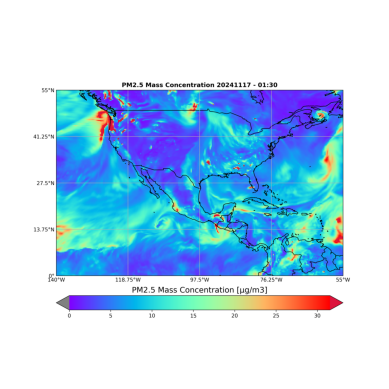

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import glob

OP = dir +"/Plots/"
# Get a list of all PNG files in the directory
file_list = sorted(glob.glob(OP+'GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(user_date)+"_*"+bounds+v+".png"))

print (file_list)

# Create a figure and axes
fig, ax = plt.subplots()

# Turn off axis
ax.axis('off')

# Function to update the image for each frame
def update_image(i):
    """Updates the image in the animation."""
    image = plt.imread(file_list[i])
    ax.imshow(image)
    #ax.set_title(f"Frame {i+1}")  # Optional: display frame number
    return ax,  # Comma is needed for blit=False

# Create the animation
ani = animation.FuncAnimation(fig, update_image, frames=len(file_list), interval=500, blit=False, repeat=False) # repeat=False to stop after one loop

# To save the animation as a GIF (optional):
ani.save(OP + 'animation.gif', writer='imagemagick', fps=2)  # Adjust fps as needed


In [ ]:
#Step -15  Processing for GEOS-CF
# This function will process GEOS-FP file (read, map, extract, and save)
user_input=2
user_date=20241116
if user_input == 2:
  user_input3 = 0
  while (user_input3 > 5) or (user_input3 < 1):
    user_input3 = int(input("Enter Variable to Process: \
                      \n1. CO   : Carbon Monoxide volume mixing ratio dry air \
                      \n2. NO2  : Nitrogen dioxide volume mixing ratio dry air\
                      \n3. O3   : Ozone volume mixing ratio dry air\
                      \n4. PM25 : PM2.5 Concentration \
                      \n5. SO2  : SO2 Surface Mass Concentration volume mixing ratio dry air\
                      \n (Enter numeric values 1-5): "))
    if (user_input3 > 10) or (user_input3 < 1):
      print ("\n****Wrong Input - Try Again****\n")
  print ("Processing GEOS-CF")

  file_list = sorted(glob.glob(dir+'GEOS-CF.v01.rpl.aqc_tavg_1hr_g1440x721_v1.'+str(user_date)+"*z.nc4"))

  if len(file_list)==0:
     print ("Data not found on local dir - Downloading from NASA SERVER")
     GEOS_CF(user_date,dir)
  file_list = sorted(glob.glob(dir+'GEOS-CF.v01.rpl.aqc_tavg_1hr_g1440x721_v1.'+str(user_date)+"*z.nc4"))
  for fname in file_list[:8]:

      vars = ['CO','NO2','O3','PM25_RH35_GCC','SO2']
      # Open the dataset with xarray
      ds = xr.open_dataset(fname)

      for dim in ds.dims:
        if ds.sizes[dim] == 1:
          ds = ds.squeeze(dim=dim)
      # Select data within the specified domain
      ds_subset = ds.sel(lon=slice(domain[0], domain[1]), lat=slice(domain[3], domain[2]))
      lon, lat = np.meshgrid(ds_subset.lon, ds_subset.lat) # adjusting dimensions for plotting

      v = vars[user_input3-1]
      data = ds_subset[v]
      print ("Processing :", v)

      title,cbarname,vmin,vmax,bins = plotname2(v)
      colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']

      cmap = mpl.colors.ListedColormap(colors) # Change to ListedColormap(colors)
      norm = mpl.colors.BoundaryNorm(bins, cmap.N) # Change to BoundaryNorm(bins, cmap.N)

      t1,t2 = fname[-9:-7],fname[-7:-5]

      fig = plt.figure(figsize=[10, 10],dpi=300) # setting figure size and DPI for image resolution
      ax = plt.axes(projection=ccrs.PlateCarree())

      lon_formatter = LongitudeFormatter(zero_direction_label = True)
      lat_formatter = LatitudeFormatter()

      ax.xaxis.set_major_formatter(lon_formatter)
      ax.yaxis.set_major_formatter(lat_formatter)
      ax.set_xticks(lon_ticks, crs = ccrs.PlateCarree())
      ax.set_yticks(lat_ticks, crs = ccrs.PlateCarree())

      #Set lat/lon ticks and gridlines
      ax.tick_params(length = 0,  labelsize = 10)
      ax.coastlines(resolution = '50m', zorder = 3)
      ax.add_feature(cartopy.feature.BORDERS)
      ax.set_extent(domain,crs=ccrs.PlateCarree())

      plt.title(f'{title} {user_date} - {t1}:{t2}', ma = 'center', size = 12, weight = 'bold')
      #if len(cities) > 0:
      #    Plot_Cities(ax)
      #cmap = plt.cm.rainbow
      #cmap.set_under("grey")
      #cmap.set_over("crimson")

      im = ax.pcolormesh(lon,lat,data,cmap=cmap,
                         #vmin = vmin,vmax = vmax,
                         norm=norm,
                         transform=ccrs.PlateCarree())
      #im = data.plot(ax=ax, norm=norm,
                             #cmap=cmap,
                            #transform=ccrs.PlateCarree(),  # Specify transformation for correct projection
                            #cbar_kwargs={'shrink': 0.8, 'label': concentration_monthly.attrs.get('units', '')})  # Adjust colorbar

      cbar = fig.colorbar(im, extend="both",orientation="horizontal",pad = 0.07)
      cbar.ax.set_title(cbarname,size = 15)
      plt.grid(True)
      plt.show()
      OP = dir +"/Plots/"
      if not os.path.exists(OP):
        os.makedirs(OP)
      fname1 = 'GEOS-CF.v01.rpl.aqc_tavg_1hr_g1440x721_v1.'+str(user_date)+bounds
      fig.savefig(OP+fname1+v+'.png') # Saving image as PNG file
      plt.close()
      del ds_subset, lon, lat, data, im, cbar
      gc.collect()


In [ ]:
# Step -16  Processing for MERRA2 data
# This function will process MERRA2 file (read, map, extract, and save)
user_input=3
user_date = 20241001
if user_input == 3:
  user_input3 = 0
  while (user_input3 > 8) or (user_input3 < 1):
    user_input3 = int(input("Enter Variable to Process: \
                      \n1. TOTEXTTAU : Total Aerosol Extinction AOT \
                      \n2. OCSMASS   : Organic Carbon Surface Mass Concentration \
                      \n3. SO2SMASS  : SO2 Surface Mass Concentration \
                      \n4. SO4SMASS  : SO4 Surface Mass Concentration \
                      \n5. SSSMASS25 : Sea Salt Surface Mass Concentration \
                      \n6. DUSMASS25 : Dust Surface Mass Concentration \
                      \n7. BCSMASS   : Black Carbon Surface Mass Concentration \
                      \n8.PM25      : PM2.5 Mass Concentration  \
                      \n (Enter numeric values 1-8): "))
    if (user_input3 > 8) or (user_input3 < 1):
      print ("\n****Wrong Input - Try Again****\n")
  print ("Processing Merra-2")
  var = ['TOTEXTTAU','OCSMASS','SO2SMASS','SO4SMASS','SSSMASS25','DUSMASS25','BCSMASS']
  vars = ','.join(var+["time","lat","lon"])
  file_list = glob.glob(dir+'MERRA2_400.tavg1_2d_aer_Nx.'+str(user_date)+'.nc4')
  if len(file_list)==0:
    print ("Data not found on local dir - Downloading from NASA SERVER")
    MERRA_2(user_date,dir,vars)
  file_list = glob.glob(dir+'MERRA2_400.tavg1_2d_aer_Nx.'+str(user_date)+'.nc4')
  for fname in file_list:
      lon,lat,TOTEXTTAU,OCSMASS,SO2SMASS,SO4SMASS,SSSMASS25,DUSMASS25,BCSMASS,PM25 = readfile3(fname=fname,domain=domain)
      vars = var + ["PM25"]
      var_dict = {
          'TOTEXTTAU':TOTEXTTAU,
          'OCSMASS':OCSMASS,
          'SO2SMASS':SO2SMASS,
          'SO4SMASS':SO4SMASS,
          'SSSMASS25':SSSMASS25,
          'DUSMASS25':DUSMASS25,
          'BCSMASS':BCSMASS,
          'PM25':PM25
      }
      v = vars[user_input3-1]
      data = var_dict[v]

      print ("Processing :", v)
      title,cbarname = plotname(v)
      fig = plt.figure(figsize=[10, 10],dpi=300) # setting figure size and DPI for image resolution
      ax = plt.axes(projection=ccrs.PlateCarree())

      lon_formatter = LongitudeFormatter(zero_direction_label = True)
      lat_formatter = LatitudeFormatter()
      ax.xaxis.set_major_formatter(lon_formatter)
      ax.yaxis.set_major_formatter(lat_formatter)
      ax.set_xticks(lon_ticks, crs = ccrs.PlateCarree())
      ax.set_yticks(lat_ticks, crs = ccrs.PlateCarree())

      #Set lat/lon ticks and gridlines
      ax.tick_params(length = 0,  labelsize = 10)
      ax.coastlines(resolution = '50m', zorder = 3)
      ax.add_feature(cartopy.feature.BORDERS)
      ax.set_extent(domain,crs=ccrs.PlateCarree())

      plt.title(f'{title} {user_date}', ma = 'center', size = 12, weight = 'bold')
      #if len(cities) > 0:
      #    Plot_Cities(ax)
      cmap = plt.cm.rainbow
      cmap.set_under("grey")
      cmap.set_over("crimson")

      vmin = 0
      vmax = np.percentile(data,99.5)
      im = ax.pcolormesh(lon,lat,data,cmap=cmap,vmin = vmin,vmax = vmax,transform=ccrs.PlateCarree())

      cbar = fig.colorbar(im, extend="both",orientation="horizontal",pad = 0.07)
      cbar.ax.set_title(cbarname,size = 15)
      plt.grid(True)
      plt.show()
      OP = dir
      fname1 = 'MERRA2_400.tavg1_2d_aer_Nx'+str(user_date)+bounds
      if not os.path.exists(OP):
        os.makedirs(OP)
      fig.savefig(OP+fname1+v+'.png')


      ## Ask USER to SAVE as CSV
      user_input4 = (input("Do you want to save variable to csv file? (yes/no):  ")).lower()
      while not((user_input4 == ('yes')) | (user_input4 == ('no'))):
        user_input4 = (input("Please type 'yes' or 'no' : ")).lower()

      if user_input4 == 'yes':
        print ("Save File") # Just for testing
        DF = pd.DataFrame()
        #print (lat.shape)
        DF["lat"]= np.ravel(lat)
        DF["lon"]= np.ravel(lon)
        for name,variable in var_dict.items():
          DF[name]=np.ravel(variable)
        DF.to_csv(OP+fname1+'.csv',sep=",",index=False,na_rep="nan")


      #### ASK USER to print for specific location
      user_input4 = (input("Do you want to Process a specific Location within Domain? (yes/no):  ")).lower()
      while not((user_input4 == ('yes')) | (user_input4 == ('no'))):
        user_input4 = (input("Please type 'yes' or 'no' : ")).lower()
      if user_input4 == 'yes':
        getpointdata2(lat,lon,data)


# **Comparision**

In [ ]:
def find_closest_lat_lon(df, target_lat, target_lon):
    """
    Finds the closest latitude and longitude in a DataFrame to a target latitude and longitude.

    Args:
        df (pd.DataFrame): DataFrame containing latitude and longitude columns.
        target_lat (float): Target latitude.
        target_lon (float): Target longitude.

    Returns:
        tuple: Closest latitude and longitude from the DataFrame.
    """

    # Calculate distances using Haversine formula
    df['distance'] = df.apply(
        lambda row: haversine(target_lon, target_lat, row['Longitude'], row['Latitude']),
        axis=1
    )

    # Find the index of the minimum distance
    closest_index = df['distance'].idxmin()

    # Get the closest latitude and longitude
    closest_lat = df.loc[closest_index, 'Latitude']
    closest_lon = df.loc[closest_index, 'Longitude']

    return closest_lat, closest_lon

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r



In [ ]:
def plot_AQI(df, city, species):
    max1=(df.max().max()//50 + 1)*50
    max1
    species = Parameter

    # --- Creating the Plot ---

    # Create a new figure with specified dimensions.
    fig = plt.figure(figsize=(12, 6))
    # Add a subplot to the figure (1x1 grid, first subplot).
    ax = fig.add_subplot(111)

    # Plot the time series data with styling.
    df.plot(ax=ax, label=city, color=['royalblue','black'], marker='o', linestyle='-',
                        markersize=8, linewidth=2)

    # --- Plot Enhancements ---

    # Add gridlines for better readability.
    ax.grid(True, linestyle='--', alpha=0.7)
    # Remove top and right spines of the plot frame.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Rotate x-axis tick labels for better visibility.
    ax.xaxis.set_tick_params(rotation=45, labelsize=12)
    # Adjust y-axis tick label size.
    ax.yaxis.set_tick_params(labelsize=12)

    # Generate dynamic title and labels.
    p_end = df.index[-1].strftime("%Y%m%d") # Extract end date from period.
    p_start = df.index[0].strftime("%Y%m%d")  # Extract start date from period.
    save_name = '3 Hour Average {} from {} to {} - {}'.format(species, p_start, p_end, city)
    ax.set_title(save_name, fontsize=16, fontweight='bold')  # Set plot title.
    ax.set_xlabel('Date', fontsize=14)  # Set x-axis label.
    ax.set_ylabel(f'{species} Concentration ({unit})',
                  fontsize=14)  # Set y-axis label.

    # Add legend and adjust layout.
    ax.legend(fontsize=12)
    ax.set_ylim(0, max1)  # Set y-axis limits.


    # --- AQI Background Coloring ---

    # Define AQI bins, labels, and colors.
    if species == 'PM25':
      bins = [0, 9.0, 35.5, 55.5, 125.5, 225.5, 1000]
    elif species == 'no2':
      bins =  [0, 55, 115, 255, 355, 425, 1000]
    elif species == 'go3':
      bins =  [0, 55, 70, 85, 105, 200, 1000] # Ozone AQI breakpoints
    labels = ['Good', 'Moderate', 'Unhealthy for\nSensitive Groups',
                'Unhealthy', 'Very Unhealthy', 'Hazardous']
    colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']


    bins = sorted([0, 9.0, 35.5, 55.5, 125.5, 225.5, 1000]  + [max1])
    tick_positions = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
    bins = [x for x in bins if x <= max1]

    # Add background color bands for AQI categories.
    for i in range(len(bins) - 1):
        ax.axhspan(bins[i], bins[i + 1], facecolor=colors[i], alpha=0.2)

    # --- Add Right Y-Axis Labels ---

    # Create a secondary y-axis for AQI labels.
    ax2 = ax.twinx()

    # Set y-axis ticks and labels for AQI categories.
    tick_positions = bins[:-1] + np.diff(bins) * 0.5
    ax2.set_yticks(tick_positions)
    ax2.set_ylim(0, max1)
    ax2.set_yticklabels(labels[:len(bins)-1], fontsize=10)

    plt.tight_layout()  # Adjust plot layout for better spacing.
    return fig, ax


In [ ]:
dir='/content/drive/MyDrive/Guatemala_Training/M5/GEOS_FP/'
date_range = pd.date_range("20241102","20241110",freq="D").strftime("%Y%m%d")
for date in date_range:
  user_date = int(date)


  #file_list = glob.glob(dir+'GEOS.fp.fcst.tavg3_2d_aer_Nx.'+str(user_date)+'_*V01.nc4')
  #print ("Data not found on local dir - Downloading from NASA SERVER")
  GEOS_FP(user_date,dir) # in case download required

In [ ]:
from copy import copy as dc

In [ ]:

cities = {
    "Mexico City": [19.4326,-99.1332 ],
    "Guatemala City": [14.6349,-90.5069 ],
    "Belize City":  [17.5046,-88.1962 ],
    "San Francisco" :[37.77, -122.42]
}

#city = "Guatemala City"

date_range = pd.date_range("20241101","20241110",freq="D").strftime("%Y%m%d")

file_list = sorted(glob.glob(dir+'GEOS.fp.fcst.tavg3_2d_aer_Nx.202411*.nc4'))
ds = xr.open_mfdataset(file_list)
GM = pd.read_csv("/content/drive/MyDrive/Guatemala_Training/EPA/PM25_20241101_20241130.csv",index_col=0)

Mexico City 19.4326 -99.1332
4448


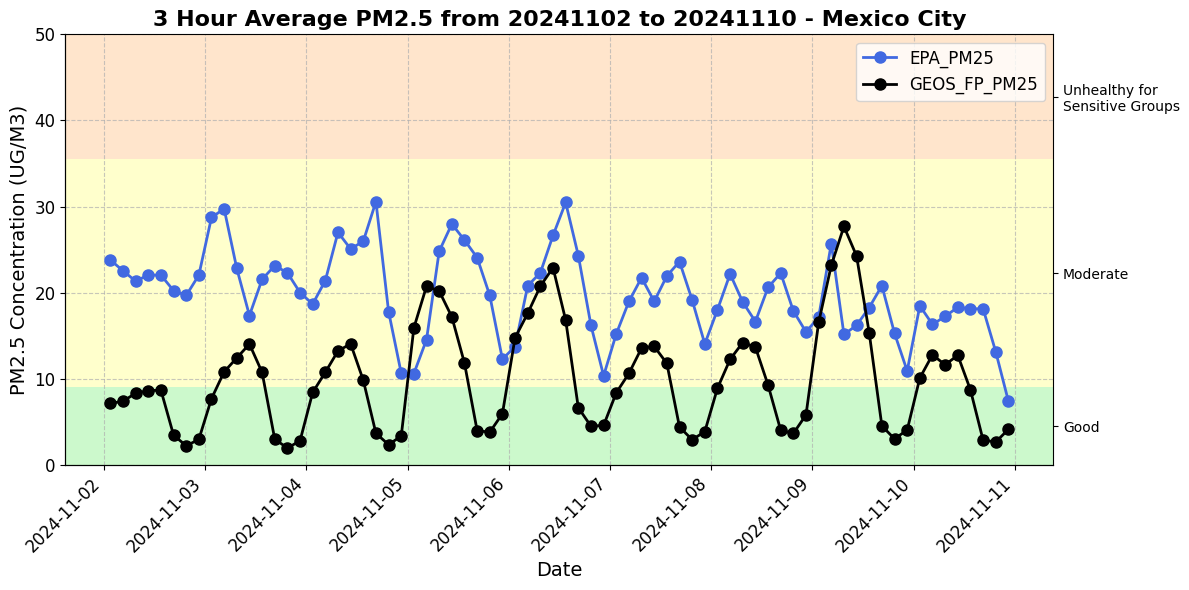

Guatemala City 14.6349 -90.5069
4448


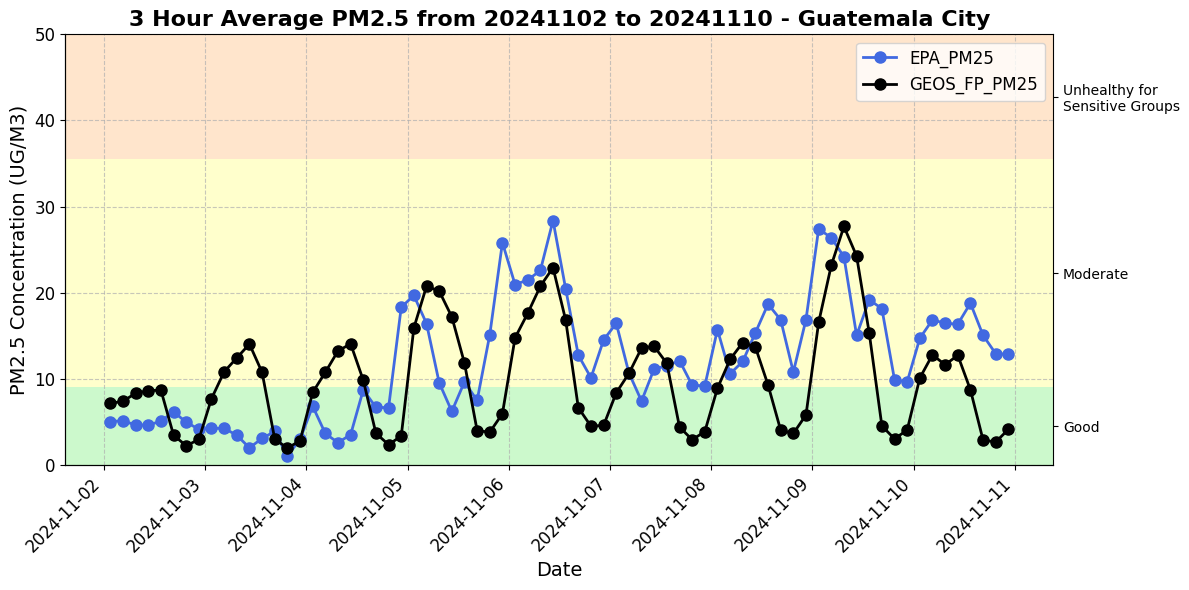

Belize City 17.5046 -88.1962
4448


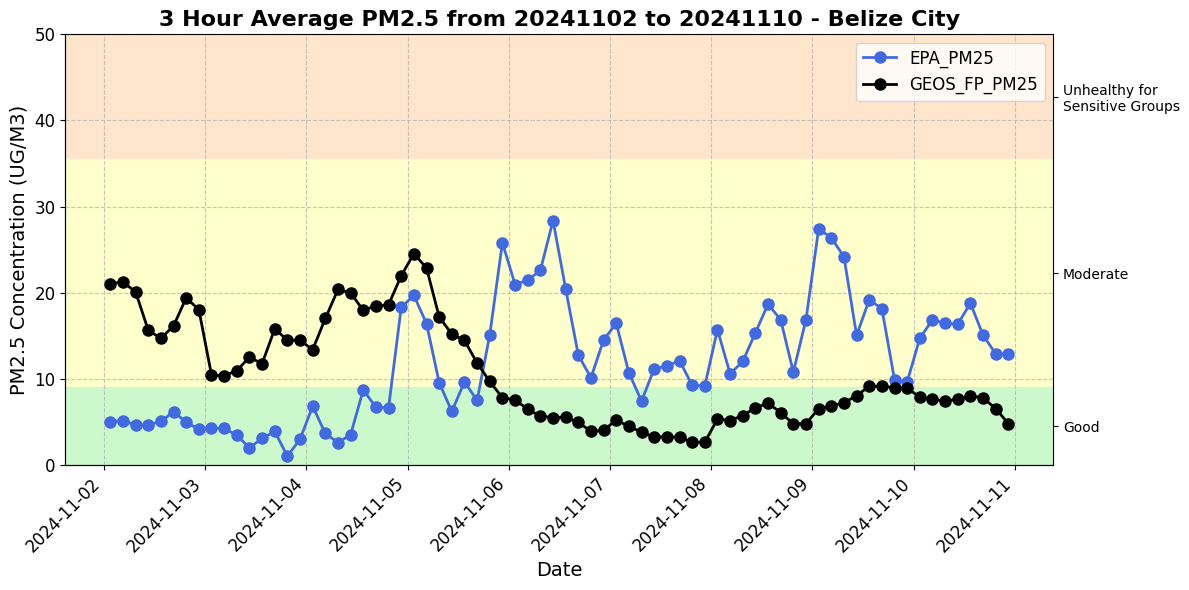

San Francisco 37.77 -122.42
4448


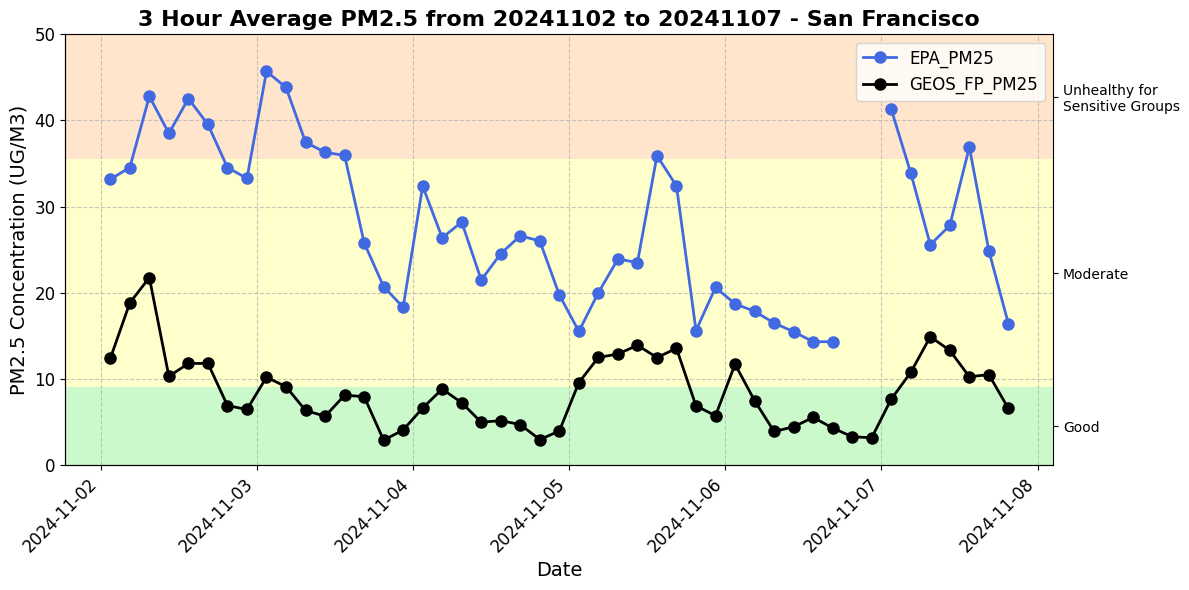

In [ ]:
for city in cities:
  gm  = dc(GM)
  city_lat, city_lon = cities[city]
  print (city,city_lat,city_lon)

  #Process EPA files
  closest_lat, closest_lon = find_closest_lat_lon(gm, city_lat, city_lon)

  print (len(gm))
  gm  = gm[(gm['Latitude'] == closest_lat)]
  gm  = gm[(gm['Longitude'] == closest_lon)]
  gm[gm.Value < 0] = np.nan
  gm[gm.Value > 1000]=np.nan
  gm = gm.dropna()
  gm.index = pd.to_datetime(gm.UTC)
  unit = gm.Unit[0]
  Parameter = gm.Parameter[0]

  gm = gm.drop(columns=['UTC','Unit','Parameter'])

  gm = gm.resample('3H').mean()
  gm.index = pd.to_datetime(gm.index) + pd.Timedelta(1.5, unit='h')

  #Process Forecast
  if not os.path.exists(dir+f"/GEOS_FP_PM25_{city}.csv"):
    ds_subset = ds.sel(lat=city_lat, lon=city_lon, method='nearest')
    ds_subset['PM25'] = (ds_subset['DUSMASS25'] + ds_subset['SSSMASS25'] +
                              (1.29 * ds_subset['NISMASS25']) + ds_subset['BCSMASS'] +
                            ds_subset['OCSMASS'] + (ds_subset['SO4SMASS'] * 1.375)) * 1e9
    DF = ds_subset['PM25'].to_dataframe()
    DF.to_csv(dir+f"/GEOS_FP_PM25_{city}.csv")
  else:
    DF = pd.read_csv(dir+f"/GEOS_FP_PM25_{city}.csv",index_col=0)
  DF.index.name= 'UTC'
  DF.index = pd.to_datetime(DF.index)
  DF[DF.PM25 < 0] = np.nan
  DF[DF.PM25 > 1000] = np.nan
  DF = pd.merge(gm,DF,on="UTC")
  DF.rename(columns = {'Value':'EPA_PM25','PM25':'GEOS_FP_PM25'},inplace=True)
  DF = DF[['EPA_PM25','GEOS_FP_PM25']]
  fig, ax = plot_AQI(DF, city, Parameter)
  plt.show()
